In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

import os
import zipfile
import urllib.request
import random
from IPython import display
import glob

2023-05-17 20:27:14.555121: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
BATCH_SIZE=16
LATENT_DIM=256
IMG_SIZE=128

In [3]:
file_list = glob.glob('./data/template/*.jpg')
print(file_list[:5])

['./data/template/18 - pos_lam 918.jpg', './data/template/49-neg_lam 1030.jpg', './data/template/24 - pos_lam1088.jpg', './data/template/14 - pos_lam 904.jpg', './data/template/31 - neg_lam1063.jpg']


In [4]:
def generate_and_save_images(model, epoch, step, test_input):
    """Helper function to plot our 16 images

    Args:

    model -- the decoder model
    epoch -- current epoch number during training
    step -- current step number during training
    test_input -- random tensor with shape (16, LATENT_DIM)
    """
    predictions = model.predict(test_input)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        img = predictions[i, :, :, :] * 255
        img = img.astype('int32')
        plt.imshow(img)
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    fig.suptitle("epoch: {}, step: {}".format(epoch, step))
    #plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
    plt.show()

In [5]:
def get_dataset_images_paths(image_dir):
    '''Retorna lista de caminhos para arquivos em image_dir'''
    image_paths = glob.glob(os.path.join(image_dir, '*.jpg'))
    #image_paths = [os.path.join(image_dir, fname) for fname in file_list if os.path.isfile(fname)]
    return image_paths

# fnames = get_dataset_images_paths('./data/train/positivo')

def map_image(img_fname):
    '''preprocessa imagens em img_fname'''
    
    img_raw = tf.io.read_file(img_fname)
    image = tf.image.decode_jpeg(img_raw)
    
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.reshape(image, shape=(IMG_SIZE, IMG_SIZE, 3,))
    
    return image
    


In [7]:
# pega os nomes dos arquivos na pasta template
paths = get_dataset_images_paths('./data/template')

# randomiza a array de nomes de arquivo
random.shuffle(paths)

# pega o tamanho da lista de nomes de arquivos
# pega 80% dos nomes na lista para treinamento e 20% para validação
paths_len = len(paths)
train_paths_len = int(paths_len * 1.0)

train_paths = paths[:train_paths_len]
#validation_paths = paths[train_paths_len:]

# configura o datasete de treinamento
training_ds = tf.data.Dataset.from_tensor_slices((train_paths))
training_ds = training_ds.map(map_image)
training_ds = training_ds.shuffle(100).batch(BATCH_SIZE)

# configura o datasete de validação
#valid_ds = tf.data.Dataset.from_tensor_slices((validation_paths))
#valid_ds = valid_ds.map(map_image)
#valid_ds = valid_ds.batch(BATCH_SIZE)

print(f'number of batches in the training set: {len(training_ds)}')
#print(f'number of batches in the validation set: {len(valid_ds)}')


number of batches in the training set: 7


In [12]:
def display_faces(dataset, size=9):
    '''Takes a sample from a dataset batch and plots it in a grid.'''
    dataset = dataset.unbatch().take(size)
    n_cols = 3
    n_rows = size//n_cols + 1
    plt.figure(figsize=(20, 20))
    i = 0
    for image in dataset:
        i += 1
        disp_img = np.reshape(image, (128,128,3))
        plt.subplot(n_rows, n_cols, i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(disp_img)


def display_one_row(disp_images, offset, shape=(28, 28)):
    '''Displays a row of images.'''
    for idx, image in enumerate(disp_images):
        plt.subplot(3, 10, offset + idx + 1)
        plt.xticks([])
        plt.yticks([])
        image = np.reshape(image, shape)
        plt.imshow(image)


def display_results(disp_input_images, disp_predicted):
    '''Displays input and predicted images.'''
    plt.figure(figsize=(15, 5))
    display_one_row(disp_input_images, 0, shape=(IMAGE_SIZE,IMAGE_SIZE,3))
    display_one_row(disp_predicted, 20, shape=(IMAGE_SIZE,IMAGE_SIZE,3))


2023-05-17 20:28:29.259382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-17 20:28:29.259673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


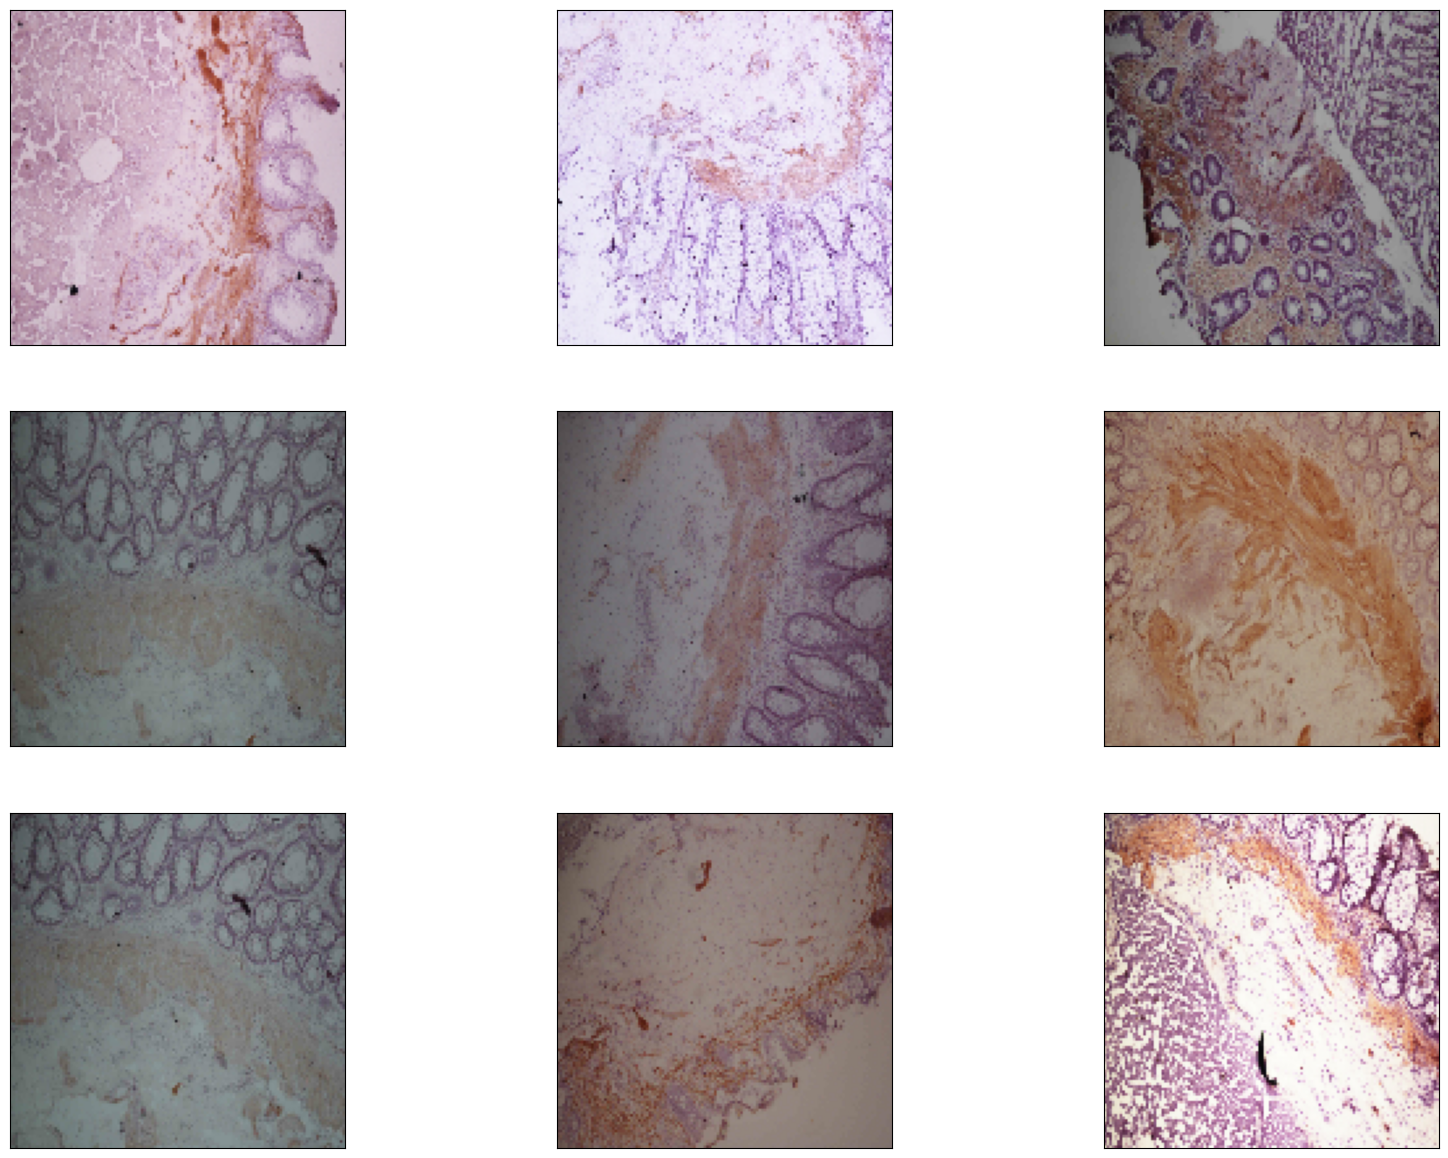

In [13]:
display_faces(training_ds)


# Build the model

In [14]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        ''' 
        Gera uma amostra randomica e combina com a saída do encoder (mu e sigma)
        
        Args: inputs -- tensor ouput do encoder
        
        Retorna: `inputs` tensores combinados com amostra randomica
        '''
        mu, sigma = inputs
        
        batch = tf.shape(mu)[0] # tamanho da amostra
        dim = tf.shape(mu)[1] # tamanho do espaço latente
        
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        
        z = mu + tf.exp(0.5 * sigma) * epsilon
        
        return z
        

# Camadas do Encoder


In [15]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense

def encoder_layers(inputs, latent_dim):
    '''
    Gera as camadas que serão utilizadas no encoder
    
    Args:
        inputs -- amostra do dataset
        latent_dim -- dimensão do espaço latente
    Retorno:
        mu -- média aprendida pelo algoritmo
        sigma -- desvio padrão da média aprendida
        batch_3.shape -- dimensão da matriz de características antes do achatamento
    '''
    #conv block 1
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=2, padding='same', activation='relu', name='encode_conv2d_1')(inputs)
    x = tf.keras.layers.BatchNormalization(name='bn_conv_1')(x)

    #conv block 2
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, padding='same', activation='relu', name='encode_conv2d_2')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_conv_2')(x)

    #conv block 3
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=2, padding='same', activation='relu', name='encode_conv2d_3')(x)
    batch_3 = tf.keras.layers.BatchNormalization(name='bn_conv_3')(x)

    x = tf.keras.layers.Flatten(name='encode_flatten')(batch_3)
    x = tf.keras.layers.Dense(units=1024, activation='relu', name='encode_dense')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_dense_1')(x)

    mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)
    sigma = tf.keras.layers.Dense(latent_dim, name='latent_sigma')(x)

    return mu, sigma, batch_3.shape
    
    

# Modelo do Encoder

In [16]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
def encoder_model(latent_dim, input_shape):
    '''
    Define o modelo do Encoder
    
    Args:
        latent_dim -- tamanho do espaço latente
        input_shape -- dimensionamento das imagens de entrada
        
    Outputs:
        model -- o modelo
        conv_shape -- dimensões da camada de características(features) antes do achatamento
    '''
    inputs = Input(shape=input_shape)
    mu, sigma, conv_shape = encoder_layers(inputs, latent_dim)
    z = Sampling()((mu, sigma))
    model = Model(inputs=inputs, outputs=[mu, sigma, z])
    
    return model, conv_shape

In [17]:
def decoder_layers(inputs, conv_shape):
    '''
    Defina as camadas do decoder
    
    Args:
        inputs -- output do encoder
        conv_shape -- dimensões da camada de features antes do achatamento (Flatten)
    
    Outputs:
        tensor com output decodificado
    '''
    units = conv_shape[1] * conv_shape[2] * conv_shape[3]
  
    # normalization
    x = tf.keras.layers.Dense(units, activation='relu', name='decoder_dense_1')(inputs)
    x = tf.keras.layers.BatchNormalization(name='bn_decoder_1')(x)
    
    # reshape
    x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name='decoder_reshape')(x)
    
    # block deconv 1
    x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2, padding='same', activation='relu', name='decoder_conv2d_1')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_decoder_2')(x)

    # block deconv 2
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=2, padding='same', activation='relu', name='decoder_conv2d_2')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_decoder_3')(x)

    # blcok deconv 3
    x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=2, padding='same', activation='relu', name='decoder_conv2d_3')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_decoder_4')(x)

    # imagem decodificada
    x = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3,3), strides=1, padding='same', activation='sigmoid', name='decoder_conv2d_final')(x)

    return x


# Modelo do Decoder

In [18]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
def decoder_model(latent_dim, conv_shape):
    '''
    Define o modelo do Decoder
    
    Args: 
        latent_dim -- dimensões do espaço latente
        conv_shape -- dimensões da última camada de convoluções antes do achatamento
        
    Outputs:
        model -- o modelo Decodificador
    '''
    inputs = Input(shape=(latent_dim,))
    outputs = decoder_layers(inputs, conv_shape)
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

### Kullback–Leibler Divergence Loss

In [19]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
    """ Calcula Kullback-Leibler Divergence (KLD) função de perda a ser adicionada a BCE loss no loop de treinamento
    Args:
        inputs -- amostra do dataset
        outputs -- saída da camada de Sampling
        mu -- média
        sigma -- desvio padrão 

    Retorna:
        KLD loss
    """
    kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
    
    return tf.reduce_mean(kl_loss) * -0.5

In [20]:
def vae_model(encoder, decoder, input_shape):
    """Defines the VAE model
    Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

    Returns:
    the complete VAE model
    """
    inputs = tf.keras.layers.Input(shape=input_shape)
    mu, sigma, z = encoder(inputs)
    reconstructed = decoder(z)
    model = tf.keras.Model(inputs=inputs, outputs=reconstructed)
    kl_loss = kl_reconstruction_loss(inputs, z, mu, sigma)
    model.add_loss(kl_loss)

    return model

In [21]:
def get_models(input_shape, latent_dim):
    """Returns the encoder, decoder, and vae models"""

    encoder, conv_shape = encoder_model(latent_dim, input_shape)
    decoder = decoder_model(latent_dim, conv_shape)
    vae = vae_model(encoder, decoder, input_shape)
    
    return encoder, decoder, vae

In [26]:
encoder, decoder, vae = get_models(input_shape=(128,128,3,), latent_dim=LATENT_DIM)

In [27]:
encoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_conv2d_1 (Conv2D)       (None, 64, 64, 32)   896         ['input_4[0][0]']                
                                                                                                  
 bn_conv_1 (BatchNormalization)  (None, 64, 64, 32)  128         ['encode_conv2d_1[0][0]']        
                                                                                                  
 encode_conv2d_2 (Conv2D)       (None, 32, 32, 64)   18496       ['bn_conv_1[0][0]']        

# Treinar o Modelo

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
loss_metric = tf.keras.metrics.Mean()
mse_loss = tf.keras.losses.MeanSquaredError()
bce_loss = tf.keras.losses.BinaryCrossentropy()

1/1 [==============================] - 0s 13ms/step


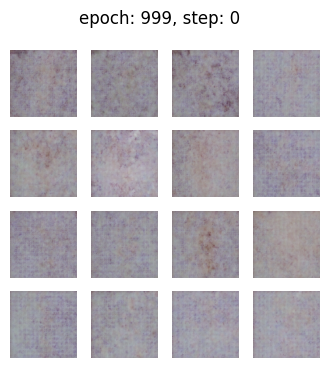

Epoch: 999 step: 0 mean loss = 286828920000.0
Epoch: 999 step: 1 mean loss = 286787930000.0
Epoch: 999 step: 2 mean loss = 286746940000.0
Epoch: 999 step: 3 mean loss = 286705940000.0
Epoch: 999 step: 4 mean loss = 286664980000.0
Epoch: 999 step: 5 mean loss = 286624020000.0
Epoch: 999 step: 6 mean loss = 286583060000.0


In [29]:
# Training loop. Display generated images each epoch

### START CODE HERE ###
epochs = 1000
### END CODE HERE ###

random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))

    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(training_ds):
        with tf.GradientTape() as tape:
            reconstructed = vae(x_batch_train)
            # Compute reconstruction loss
            flat_in = tf.reshape(x_batch_train, shape=[-1])
            flat_out = tf.reshape(reconstructed, shape=[-1])
            loss = mse_loss(flat_in, flat_out) * 128 * 128 * 3
            loss += sum(vae.losses)

        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        loss_metric(loss)

        if step % 100 == 0:
            display.clear_output(wait=False)    
            generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
        print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))

In [30]:
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])
img = decoder(random_vector_for_generation)

In [31]:
img.shape


TensorShape([16, 128, 128, 3])

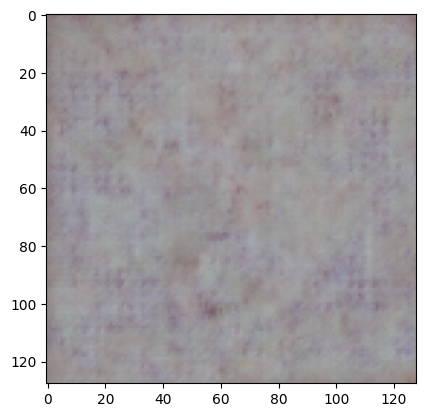

In [35]:
plt.imshow(img[8])